![alt text](UniversiteParisCite_logo_horizontal_couleur_RVB.png)

# Deep Learning Analaysis on MNIST Dataset: Data, Models & Results

Gaelle Loutfi   
M2 BI    
AY 2025/2026    


dont forget to add code comments


![alt text](MNIST_dataset_example.png)

## 0) Setup: Imports, Random Seeds, and File Paths

Before starting the analysis, we first set up the environment:

- **Imports:** We load all necessary libraries for data handling (`numpy`, `pandas`), visualization (`matplotlib`), preprocessing (`scikit-learn`), and building deep learning models (`TensorFlow/Keras`).  
- **Reproducibility:** To ensure consistent results, we fix random seeds for both NumPy and TensorFlow.  
- **Data Directory:** We specify the path where the dataset files (`.npy` format for MNIST images and labels) are stored. This makes it easier to load and manage the data later.


In [21]:
# 0) Setup: imports, random seeds, and file paths
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, auc, precision_recall_curve)

from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

np.random.seed(42)
tf.random.set_seed(42)

# Point this to the folder that contains the .npy files
DATA_DIR = "."  # change if needed


## 1) Loading the Dataset

We load the **MNIST dataset** (handwritten digit images) from pre-saved `.npy` files.  
The dataset consists of:

- **Training set:** 60,000 grayscale images of size **28×28×1** with their labels (`X_train`, `y_train`).  
- **Test set:** 10,000 grayscale images of the same shape (`X_test`, `y_test`).  

Each label is an integer from **0 to 9**, representing the digit class.  

In [22]:
# 1) Loading the images and labels from .npy files
print("Loading data from .npy files...")
X_train = np.load(os.path.join(DATA_DIR, "train_images.npy"))
y_train = np.load(os.path.join(DATA_DIR, "train_labels.npy"))
X_test  = np.load(os.path.join(DATA_DIR, "test_images.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "test_labels.npy"))

print("Shapes:")
print("  X_train:", X_train.shape, "dtype:", X_train.dtype)
print("  y_train:", y_train.shape, "dtype:", y_train.dtype)
print("  X_test :", X_test.shape,  "dtype:", X_test.dtype)
print("  y_test :", y_test.shape,  "dtype:", y_test.dtype)


Loading data from .npy files...
Shapes:
  X_train: (60000, 28, 28, 1) dtype: float32
  y_train: (60000,) dtype: uint8
  X_test : (10000, 28, 28, 1) dtype: uint8
  y_test : (10000,) dtype: uint8


From the printed shapes:
- `X_train`: `(60000, 28, 28, 1)` → 60k images, each 28×28 pixels, single channel.  
- `y_train`: `(60000,)` → one label per training image.  
- `X_test`: `(10000, 28, 28, 1)` → 10k images for evaluation.  
- `y_test`: `(10000,)` → one label per test image.  

These arrays will form the basis for training and testing our deep learning models.

### Checking the Pixel Value Range

Before preprocessing, it is important to inspect the range of pixel intensities:

In [23]:
#see if there is a need for scaling
print("RAW max/min:", X_train.max(), X_train.min())
print("RAW max/min:", X_test.max(), X_test.min())

RAW max/min: 1.0 0.0
RAW max/min: 255 0


- For the **training set**, values are already normalized between **0 and 1**.  
- For the **test set**, values range from **0 to 255**, meaning they are stored in raw 8-bit integer format.  

This mismatch indicates that we will need to **rescale the test images** (and potentially confirm consistency for all inputs) so that both training and test sets are on the same scale. Consistent scaling ensures that the model does not see different numerical ranges during training and evaluation.

In [24]:
# Preprocessing: scaling where it is needed (train)
X_test = X_test / 255.0
print("RAW max/min:", X_test.max(), X_test.min())


RAW max/min: 1.0 0.0


## 2) Visualizing Sample Images

To better understand the dataset, we display a **4×5 grid of training images** along with their labels.  

- Each image is a **handwritten digit (0–9)** in grayscale.  
- The digits show a variety of **handwriting styles**, orientations, and stroke thicknesses, which makes the classification task more challenging and realistic.  
- Visual inspection also confirms that the data has been loaded correctly and that labels correspond to the digit shown in each image.  

This step is useful as an initial **sanity check** before moving on to preprocessing and model training.


Showing a 4x5 grid of sample images from the training set...


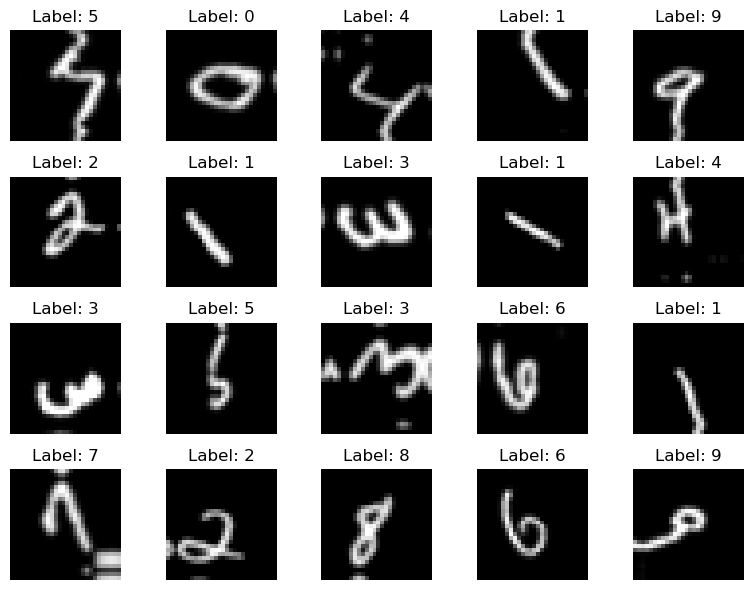

In [25]:
# 2) Visualize a few images with their labels
print("Showing a 4x5 grid of sample images from the training set...")
fig, axes = plt.subplots(4, 5, figsize=(8, 6))
axes = axes.ravel()
for i in range(20):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


## 3) Exploratory Data Analysis (EDA) and Sanity Checks

Before model training, we perform a few sanity checks on the training data:


Basic stats on pixel values (train):
  min: 0.0 max: 1.0 mean: 0.14200264 std: 0.23273616
Any NaNs in X_train? False
Any NaNs in X_test? False

Head of flattened pixel table (first 5 rows, first 10 features):
          0         1         2         3         4         5         6  \
0  0.057734  0.057734  0.057734  0.057734  0.057734  0.057734  0.057734   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.053084  0.000000  0.000000  0.012119  0.059128  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.083121  0.083121  0.083121  0.083121  0.083121  0.083121  0.083121   

          7         8         9  
0  0.057734  0.057734  0.057734  
1  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  
4  0.083121  0.083121  0.083121  

Class distribution (train):
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype:

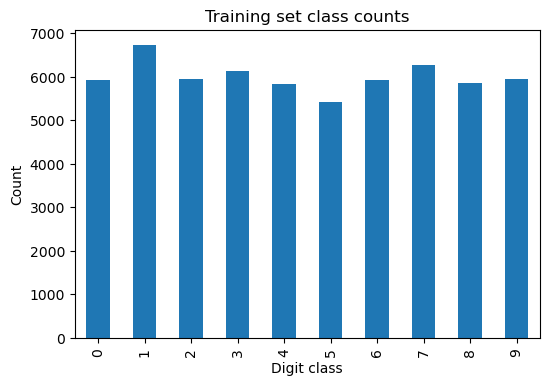

In [26]:
# 3) Initial EDA / sanity checks

print("\nBasic stats on pixel values (train):")
print("  min:", X_train.min(), "max:", X_train.max(), "mean:", X_train.mean(), "std:", X_train.std())
print("Any NaNs in X_train?", np.isnan(X_train).any())
print("Any NaNs in X_test?", np.isnan(X_test).any())

# Show a 'head' of the flattened pixels just to see structure
print("\nHead of flattened pixel table (first 5 rows, first 10 features):")
flat_head = X_train.reshape(len(X_train), -1)
print(pd.DataFrame(flat_head).iloc[:5, :10])

# Label distribution
unique, counts = np.unique(y_train, return_counts=True)
class_counts = pd.Series(counts, index=unique).sort_index()
print("\nClass distribution (train):")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar")
plt.title("Training set class counts")
plt.xlabel("Digit class")
plt.ylabel("Count")
plt.show()


- **Pixel statistics:**  
  - Minimum = 0.0, Maximum = 1.0  
  - Mean ≈ 0.14, Standard deviation ≈ 0.23  
  - No missing values (`NaN`) were found in either training or test sets.  

- **Data structure preview:**  
  - By flattening the images, we can confirm that each row corresponds to a digit image with normalized pixel intensities.  

- **Class distribution:**  
  - The dataset contains roughly **5,400–6,700 samples per class**.  
  - The distribution is fairly balanced across the ten digit categories (0–9), which is ideal for training classification models without introducing bias toward specific digits.  

The bar plot above confirms that **each digit class is well represented** in the training set.  



## 4) Preprocessing: One-Hot Encoding and Data Splits

To prepare the MNIST dataset for training deep learning models, we apply the following preprocessing steps:

In [27]:
# 4) Preprocessing: one-hot encode labels, and split train/val


num_classes = len(np.unique(y_train))
print("Detected number of classes:", num_classes)

# One-hot encoding for Keras training
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test,  num_classes=num_classes)

# Split a validation set out of training data
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train_oh, test_size=0.15, random_state=42, stratify=y_train
)
y_val_labels = np.argmax(y_val, axis=1)  # for some plots later

print("Train/Val/Test sizes:", X_train_full.shape[0], X_val.shape[0], X_test.shape[0])

# Prepare shapes for MLP (flatten) and CNN (H, W, 1)
X_train_mlp = X_train_full.reshape((len(X_train_full), -1))
X_val_mlp   = X_val.reshape((len(X_val), -1))
X_test_mlp  = X_test.reshape((len(X_test), -1))

# Optional standardization for the MLP (mean=0, std=1) — CNN will use raw [0,1] images
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_val_mlp   = scaler.transform(X_val_mlp)
X_test_mlp  = scaler.transform(X_test_mlp)

# # CNN shape
def to_float01(x):
    x = x.astype("float32")
    if x.max() > 1.5:   # only normalize if still in [0..255]
        x = x / 255.0
    return x

def ensure_channel_last(x):
    return x if x.ndim == 4 else x[..., np.newaxis]

X_train_cnn = ensure_channel_last(to_float01(X_train_full))
X_val_cnn   = ensure_channel_last(to_float01(X_val))
X_test_cnn  = ensure_channel_last(to_float01(X_test))



print("MLP input shape:", X_train_mlp.shape[1])
print("CNN input shape:", X_train_cnn.shape[1:])

# Optional sanity checks
# assert X_train_cnn.ndim == 4 and X_train_cnn.shape[-1] == 1
# print("CNN tensors:", X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)


Detected number of classes: 10
Train/Val/Test sizes: 51000 9000 10000
MLP input shape: 784
CNN input shape: (28, 28, 1)


- **Number of classes:** The dataset contains **10 classes** (digits 0–9).  

- **Label encoding:**  
  - Labels are converted to **one-hot encoded vectors** so that each digit is represented as a 10-dimensional vector (e.g., digit `3` → `[0,0,0,1,0,0,0,0,0,0]`).  
  - This format is required by Keras when training with categorical cross-entropy loss.  

- **Train/Validation/Test split:**  
  - Training: **51,000 samples**  
  - Validation: **9,000 samples** (15% of training set, stratified to preserve class proportions)  
  - Test: **10,000 samples**  

- **Feature preparation for different model types:**  
  - **MLP (Multilayer Perceptron):** Images are flattened into **784-dimensional vectors** (28×28 pixels).  
  - **CNN (Convolutional Neural Network):** Images are kept in their original **28×28×1** format (height, width, channel).  

- **Normalization:**  
  - For MLP input, we apply **standardization** (mean = 0, std = 1).  
  - For CNN input, pixel values are kept in the range **[0, 1]**.  

These preprocessing steps ensure that both architectures (MLP and CNN) receive data in a form that is most suitable for their training.

## 5) Dimensionality Reduction: PCA vs t-SNE

To visualize the structure of the MNIST dataset in a lower-dimensional space, we apply two common dimensionality reduction techniques on a subset of **8,000 training samples**:    
(A subset is used instead of the full 60,000 images because **t-SNE is computationally expensive** and becomes very slow on large datasets.)


Running PCA on 8000 samples...


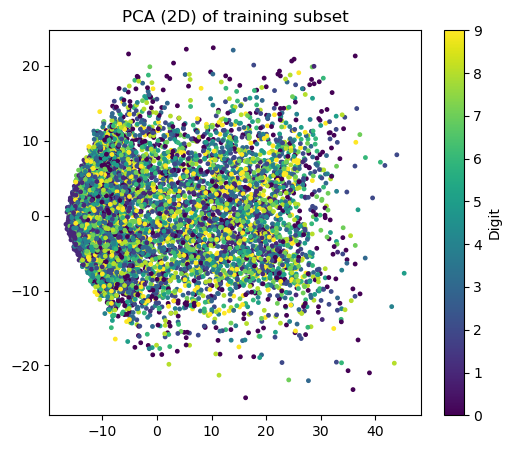

Running t-SNE (this can take a bit)...


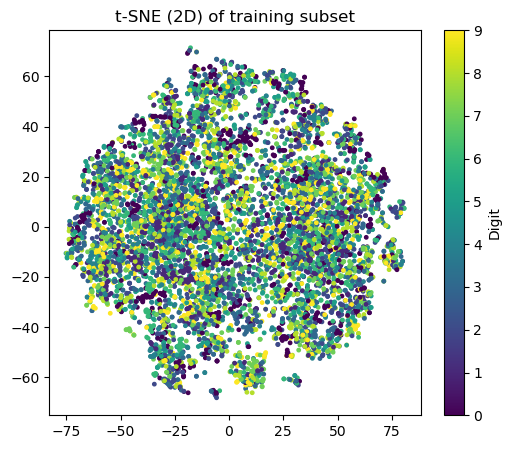

In [28]:
# 5) Dimensionality reduction plots (use a subset to keep it quick)
subset = 8000 if X_train_mlp.shape[0] > 8000 else X_train_mlp.shape[0]
X_sub = X_train_mlp[:subset]
y_sub = np.argmax(y_train_full[:subset], axis=1)

print(f"Running PCA on {subset} samples...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sub)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sub, s=6)
plt.title("PCA (2D) of training subset")
plt.colorbar(scatter, label="Digit")
plt.show()

print("Running t-SNE (this can take a bit)...")
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_sub)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sub, s=6)
plt.title("t-SNE (2D) of training subset")
plt.colorbar(scatter, label="Digit")
plt.show()


- **Principal Component Analysis (PCA):**  
  - A linear technique that projects the data into directions of maximum variance.  
  - In the 2D plot, digits are widely scattered and strongly overlapping, showing that PCA alone cannot fully separate digit classes.  
  - This is expected, since PCA only captures **global variance** and does not model complex nonlinear relationships.

- **t-distributed Stochastic Neighbor Embedding (t-SNE):**  
  - A nonlinear technique that focuses on preserving **local neighborhood structures**.  
  - The 2D visualization shows more noticeable **clusters of digits**, although some classes still overlap.  
  - This indicates that the raw pixel features already contain discriminative information, but perfect class separation requires a more powerful model.

**Interpretation:**  
PCA provides a quick global overview but is limited for classification insight, whereas t-SNE better highlights digit clusters, reinforcing the motivation for using **deep learning models** to learn complex feature representations.

## 6) Class Weights for Handling Imbalance

To account for potential class imbalance during training, we compute **class weights** using scikit-learn’s `compute_class_weight` function.  

- Even though MNIST is **fairly balanced** (each digit class has around 5,400–6,700 samples), small differences exist.  
- Class weights are inversely proportional to class frequency:  
  - Rare classes (e.g., digit **5**) get weights slightly **above 1** (≈ 1.11).  
  - More frequent classes (e.g., digit **1**) get weights slightly **below 1** (≈ 0.89).  

These weights can be passed to the training procedure so that the model **pays more attention to underrepresented classes**, reducing bias.  
While not strictly necessary for MNIST, it is a **good practice** in general classification problems, especially when dealing with real-world datasets that are often highly imbalanced

In [29]:
# 6) Compute class weights if classes are imbalanced (harmless even if fairly balanced)
labels_train_full = np.argmax(y_train_full, axis=1)
classes = np.unique(labels_train_full)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels_train_full)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weights)


Class weights: {0: 1.012909632571996, 1: 0.889897051125458, 2: 1.0071090047393365, 3: 0.9786989061600461, 4: 1.026983487716472, 5: 1.1067708333333333, 6: 1.0139165009940359, 7: 0.9577464788732394, 8: 1.0255379046853006, 9: 1.008503065058335}


## 7) Early Stopping Callback

To prevent **overfitting** and reduce unnecessary training time, we implement an **EarlyStopping** callback in Keras.  

- **Monitor:** `val_accuracy` → the validation accuracy is tracked after each epoch.  
- **Mode:** `'max'` → training stops when validation accuracy has stopped improving.  
- **Patience:** `6` → allows up to 6 consecutive epochs without improvement before stopping.  
- **Restore best weights:** Ensures that after stopping, the model reverts to the weights corresponding to the **highest validation accuracy**.  

This strategy helps the model generalize better by stopping training **at the optimal point**, rather than continuing and fitting noise in the training set.


In [30]:
from tensorflow.keras import callbacks

# ONLY classic EarlyStopping on validation accuracy
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True,
    verbose=1
)


## 8) Baseline MLP: Architecture, Training, and Results

**Model.** A simple fully connected network trained on standardized, flattened pixels (784 features):
- Dense(256, ReLU) → Dropout(0.30)
- Dense(128, ReLU) → Dropout(0.30)
- Dense(10, Softmax)

Compiled with **RMSprop** and **categorical cross-entropy**; metric: **accuracy**.  
Total parameters: **235,146**.

**Why this setup?**
- **ReLU** accelerates optimization and avoids saturation.
- **Dropout (30%)** regularizes the dense layers.
- **Softmax + cross-entropy** is standard for multi-class classification.
- **RMSprop** adapts the learning rate per parameter, often effective on vision baselines.

In [32]:
# 8) Baseline MLP per PDF spec
def build_mlp(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.30),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.30),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

mlp = build_mlp(X_train_mlp.shape[1], num_classes)
mlp.summary()

print("Training MLP...")

hist_mlp = mlp.fit(
    X_train_mlp, y_train_full,
    validation_data=(X_val_mlp, y_val),
    epochs=50, batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)
print("Evaluating MLP on test set...")
test_loss_mlp, test_acc_mlp = mlp.evaluate(X_test_mlp, y_test_oh, verbose=0)
print(f"MLP Test accuracy: {test_acc_mlp:.4f}")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Training MLP...
Epoch 1/50
200/200 - 2s - 8ms/step - accuracy: 0.3137 - loss: 1.9549 - val_accuracy: 0.4604 - val_loss: 1.5842
Epoch 2/50
200/200 - 1s - 4ms/step - accuracy: 0.4598 - loss: 1.5762 - val_accuracy: 0.5684 - val_loss: 1.3096
Epoch 3/50
200/200 - 1s - 4ms/step - accuracy: 0.5268 - loss: 1.4053 - val_accuracy: 0.6252 - val_loss: 1.1420
Epoch 4/50
200/200 - 1s - 4ms/step - accuracy: 0.5610 - loss: 1.3023 - val_accuracy: 0.6576 - val_loss: 1.0622
Epoch 5/50
200/200 - 1s - 4ms/step - accuracy: 0.5906 - loss: 1.2193 - val_accuracy: 0.6714 - val_loss: 1.0187
Epoch 6/50
200/200 - 1s - 4ms/step - accuracy: 0.6101 - loss: 1.1680 - val_accuracy: 0.7011 - val_loss: 0.9321
Epoch 7/50
200/200 - 1s - 4ms/step - accuracy: 0.6302 - loss: 1.1153 - val_accuracy: 0.7221 - val_loss: 0.8757
Epoch 8/50
200/200 - 1s - 4ms/step - accuracy: 0.6415 - loss: 1.0797 - val_accuracy: 0.7382 - val_loss: 0.8418
Epoch 9/50
200/200 - 1s - 4ms/step - accuracy: 0.6518 - loss: 1.0499 - val_accuracy: 0.7430 - va

**Training dynamics (50 epochs, batch size 256, with class weights and EarlyStopping):**
- Validation accuracy improved steadily from **0.4604 (epoch 1)** to around **0.838 (epoch 50)**, with small fluctuations after ~epoch 30.  
- Validation loss decreased from **1.58** at the start to about **0.52** by epoch 50, showing consistent learning and fit to the data.  
- EarlyStopping was active but did not trigger before the final epoch; the best weights were restored from **epoch 50**.  
- Final **test accuracy = 0.8491**, in close agreement with the validation performance.

**Interpretation.**
- The MLP is able to learn progressively richer representations from the flattened pixel inputs, but it plateaus around **84–85%**, which is expected for dense-only networks on MNIST.  
- The validation and test curves match closely, suggesting that **dropout regularization** prevented strong overfitting despite 235k parameters.  
- Compared to CNN results (~97%), this underlines the importance of preserving spatial structure in images: MLPs lack inductive biases that convolutional layers exploit.

**Next steps.**
- Plot learning curves (already available) to further illustrate smooth convergence.  
- Compute a **confusion matrix** to identify which digits are most frequently misclassified (likely 4 vs 9, 5 vs 6).  
- Use this MLP as a baseline reference when highlighting the performance jump of the CNN.


## 9) CNN Baseline: Architecture, Training, and Results

**Model.** A small convolutional network that preserves the 2D spatial structure of MNIST:
- [Conv(32, 3×3, ReLU) → Conv(32, 3×3, ReLU) → MaxPool → Dropout(0.30)]
- [Conv(64, 3×3, ReLU) → Conv(64, 3×3, ReLU) → MaxPool → Dropout(0.30)]
- Flatten → Dense(128, ReLU) → Dropout(0.30) → Dense(10, Softmax)  
Total parameters: **467,818**.

**Why a CNN?**  
Convolutions learn **local edge/shape features** and share weights across the image, giving a strong **inductive bias** for vision tasks. Pooling adds translation tolerance, and dropout regularizes the dense and convolutional stacks.

**Training setup.**  
- Optimizer: **RMSprop**, Loss: **categorical cross-entropy**, Metric: **accuracy**  
- Batch size **256**, up to **40** epochs, **class weights** enabled  
- **EarlyStopping** on `val_accuracy` with `patience=6` and `restore_best_weights=True`


In [ ]:
# 9) CNN baseline
def build_cnn(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.30)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn = build_cnn(X_train_cnn.shape[1:], num_classes)
cnn.summary()

print("Training CNN...")

hist_cnn = cnn.fit(
    X_train_cnn, y_train_full,
    validation_data=(X_val_cnn, y_val),
    epochs=40, batch_size=256,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)


test_loss_cnn, test_acc_cnn = cnn.evaluate(X_test_cnn, y_test_oh, verbose=0)
print(f"CNN Test accuracy: {test_acc_cnn:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN...
Epoch 1/40
200/200 - 13s - 65ms/step - accuracy: 0.4570 - loss: 1.5452 - val_accuracy: 0.7810 - val_loss: 0.6917
Epoch 2/40
200/200 - 13s - 65ms/step - accuracy: 0.7945 - loss: 0.6567 - val_accuracy: 0.9001 - val_loss: 0.3437
Epoch 3/40
200/200 - 13s - 67ms/step - accuracy: 0.8705 - loss: 0.4229 - val_accuracy: 0.9232 - val_loss: 0.2452
Epoch 4/40
200/200 - 13s - 67ms/step - accuracy: 0.9022 - loss: 0.3237 - val_accuracy: 0.9377 - val_loss: 0.2085
Epoch 5/40
200/200 - 14s - 70ms/step - accuracy: 0.9184 - loss: 0.2637 - val_accuracy: 0.9486 - val_loss: 0.1721
Epoch 6/40
200/200 - 14s - 69ms/step - accuracy: 0.9316 - loss: 0.2270 - val_accuracy: 0.9494 - val_loss: 0.1663
Epoch 7/40
200/200 - 14s - 68ms/step - accuracy: 0.9383 - loss: 0.2010 - val_accuracy: 0.9438 - val_loss: 0.1929
Epoch 8/40
200/200 - 14s - 70ms/step - accuracy: 0.9440 - loss: 0.1820 - val_accuracy: 0.9598 - val_loss: 0.1368
Epoch 9/40
200/200 - 14s - 69ms/step - accuracy: 0.9491 - loss: 0.1645 - val_acc

**Learning dynamics & early stopping.**  
- Validation accuracy climbed rapidly (≈0.90 by epoch 2, ≈0.96–0.97 by epochs 10–16).  
- Training stopped at **epoch 22** and restored the best weights from **epoch 16**.

**Test performance.**  
- **Test accuracy = 0.9714**, a large improvement over the MLP (≈0.848).  
- This gap highlights the benefit of **spatial feature learning** and parameter sharing for image classification.

**Notes & next steps.**  
- Plot learning curves to confirm convergence and check for mild overfitting after ~epoch 16.  
- Inspect a **confusion matrix** and a few **misclassified digits** to see common confusions (e.g., 4↔9, 5↔6).  

## 10) CNN Learning Curves: Convergence, Generalization, and Early Stopping

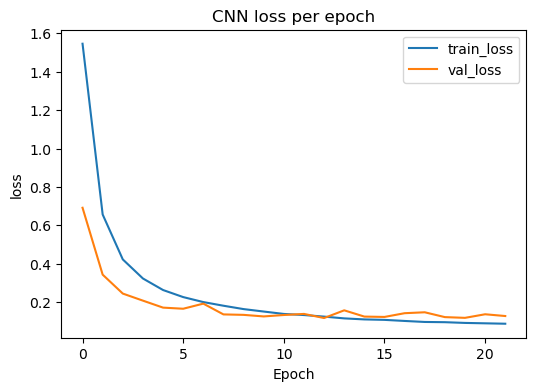

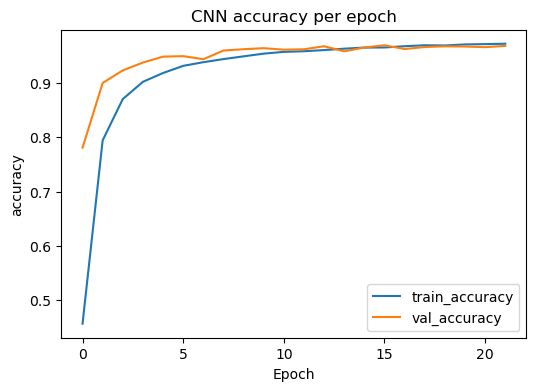

In [33]:
# 10) Plot training curves for the CNN (change to hist_mlp to inspect MLP)
def plot_history(history, title_prefix="Model"):
    metrics = [("loss", "val_loss"), ("accuracy", "val_accuracy")]
    for m, vm in metrics:
        plt.figure(figsize=(6,4))
        plt.plot(history.history[m], label=f"train_{m}")
        plt.plot(history.history[vm], label=f"val_{m}")
        plt.title(f"{title_prefix} {m} per epoch")
        plt.xlabel("Epoch")
        plt.ylabel(m)
        plt.legend()
        plt.show()

plot_history(hist_cnn, title_prefix="CNN")


**Loss curves (top).**
- **Fast initial descent (epochs 1–4):** Training loss drops from ~1.55 to ~0.30, while validation loss falls from ~0.68 to ~0.20. This indicates the model quickly learns strong low-level features (edges/strokes).
- **Validation < training (early epochs):** The orange curve sits **below** the blue curve at first. That’s expected because **Dropout(0.30)** is active only during training, which makes the *training* loss noisier/higher and the *training* accuracy lower than validation early on.
- **Stable improvement (epochs ~5–12):** Both losses continue to decline; the gap narrows, suggesting growing fit with controlled capacity.
- **Mild flattening & noise (after ~epoch 12):** Validation loss oscillates around **0.12–0.16** with small bumps (e.g., ~epochs 13–18). This is normal mini-batch noise and reflects the model nearing its bias/variance limit for this setup.
- **No divergence:** There is **no persistent rise** in validation loss while training loss keeps falling—so classic overfitting is limited.
- **Early stopping trigger:** Training halted at **epoch 22**, restoring the best weights from **epoch 16**, where validation loss/accuracy were near their optima.

**Accuracy curves (bottom).**
- **Rapid climb:** Validation accuracy jumps to **~0.90 by epoch 2** and **~0.96 by epochs 8–10**, matching the quick loss reductions.
- **Small generalization gap:** Train and validation accuracies track closely (both ~0.95–0.97 later), indicating good generalization with minimal overfitting.
- **Plateau region:** Beyond ~epoch 12, improvements are incremental (tenth-percent levels). The curve shape justifies early stopping: continued training yields negligible gains.

**Takeaways.**
- The model converges **quickly** and reaches a stable generalization regime by ~epoch 12–16.
- **Dropout** explains the early “val > train” accuracy; it’s a sign of healthy regularization, not leakage.
- With **EarlyStopping** (patience=6, monitor=`val_accuracy`), we avoid wasting epochs past the plateau and keep the best-performing weights.
- Final test accuracy (**0.9714**) aligns with the plateaued validation accuracy, confirming **good calibration** between validation and test.

## 11) Test-set Evaluation:


MLP — Classification report:
              precision    recall  f1-score   support

           0     0.9071    0.9367    0.9217       980
           1     0.9549    0.9692    0.9620      1135
           2     0.8655    0.8169    0.8405      1032
           3     0.8451    0.8317    0.8383      1010
           4     0.7864    0.7912    0.7888       982
           5     0.8055    0.7567    0.7803       892
           6     0.8702    0.8747    0.8725       958
           7     0.8838    0.8512    0.8672      1028
           8     0.7685    0.8214    0.7940       974
           9     0.7872    0.8176    0.8021      1009

    accuracy                         0.8491     10000
   macro avg     0.8474    0.8467    0.8467     10000
weighted avg     0.8495    0.8491    0.8490     10000



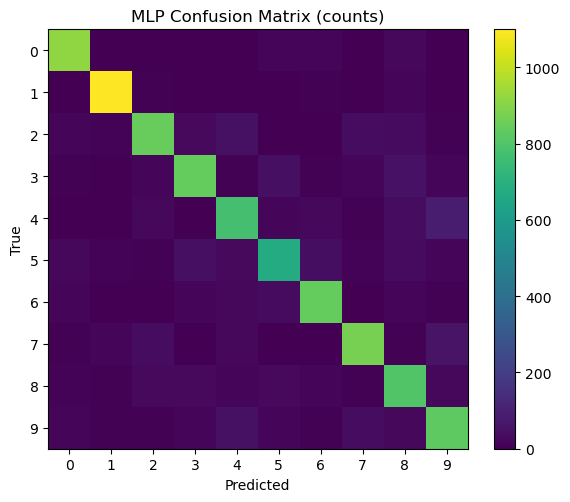

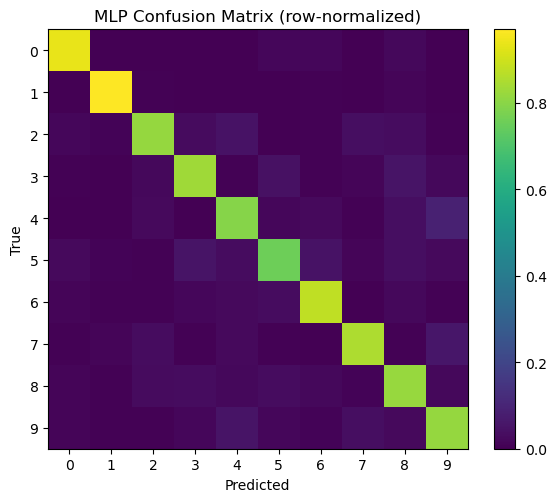

MLP ROC AUC — macro: 0.9841, micro: 0.9857


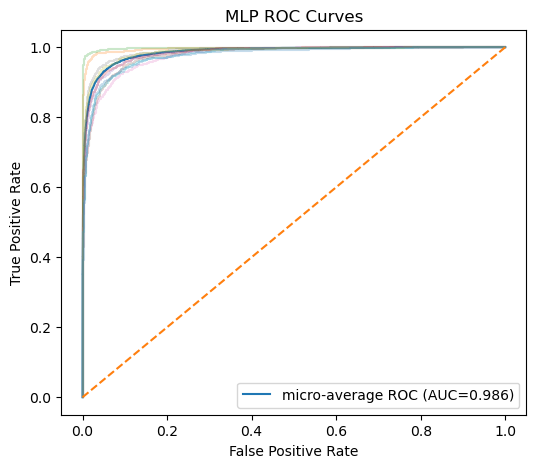

MLP PRC AUC — avg per-class: 0.9142 ± 0.0427


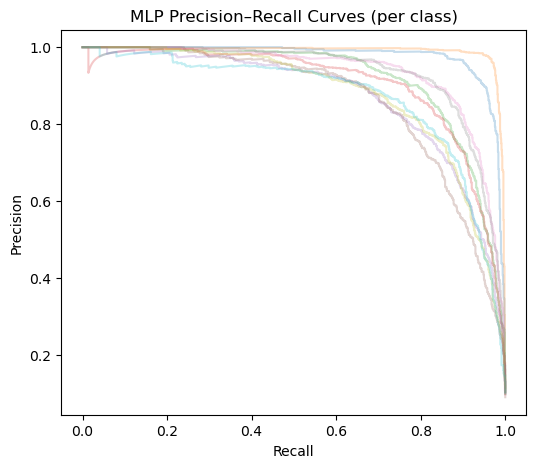


CNN — Classification report:
              precision    recall  f1-score   support

           0     0.9858    0.9918    0.9888       980
           1     0.9834    0.9903    0.9868      1135
           2     0.9580    0.9729    0.9654      1032
           3     0.9860    0.9762    0.9811      1010
           4     0.9699    0.9521    0.9609       982
           5     0.9781    0.9529    0.9654       892
           6     0.9740    0.9760    0.9750       958
           7     0.9638    0.9591    0.9615      1028
           8     0.9607    0.9784    0.9695       974
           9     0.9547    0.9604    0.9575      1009

    accuracy                         0.9714     10000
   macro avg     0.9714    0.9710    0.9712     10000
weighted avg     0.9715    0.9714    0.9714     10000



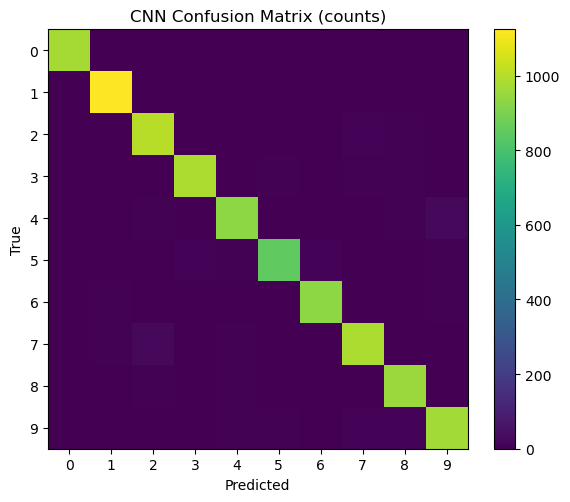

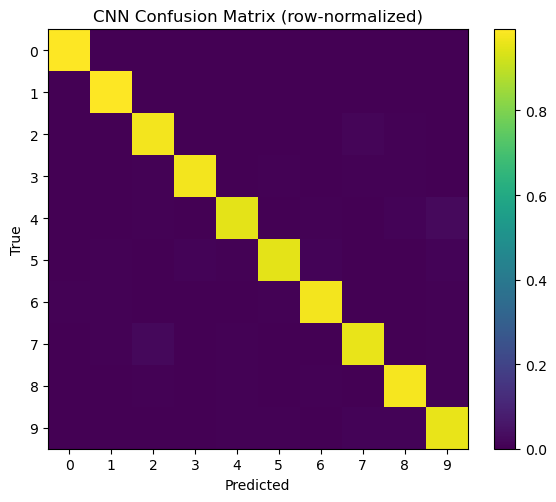

CNN ROC AUC — macro: 0.9993, micro: 0.9993


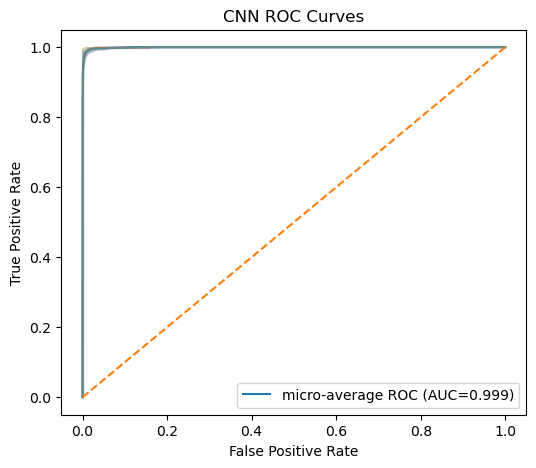

CNN PRC AUC — avg per-class: 0.9951 ± 0.0024


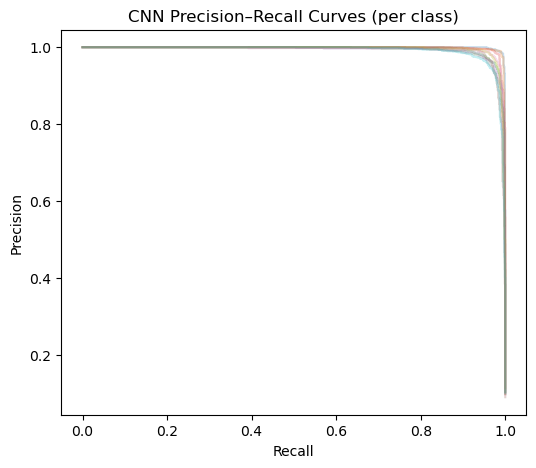

In [34]:
# 11) Metrics & plots: confusion matrices + ROC + PR curves

def evaluate_model(model, X_test_in, y_test_oh, y_test_labels, model_name="Model"):
    # Predictions
    y_prob = model.predict(X_test_in, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # Confusion matrices (raw and normalized)
    cm = confusion_matrix(y_test_labels, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    print(f"\n{model_name} — Classification report:")
    print(classification_report(y_test_labels, y_pred, digits=4))

    # Plot confusion matrices
    def plot_cm(C, title):
        plt.figure(figsize=(6,5))
        plt.imshow(C, interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        ticks = np.arange(num_classes)
        plt.xticks(ticks, ticks)
        plt.yticks(ticks, ticks)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(cm, f"{model_name} Confusion Matrix (counts)")
    plot_cm(cm_norm, f"{model_name} Confusion Matrix (row-normalized)")

    # ROC & PRC (one-vs-rest)
    # Note: For multi-class ROC/PRC, we compute macro and micro averages
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_test_labels)  # shape: (N, C)
    if y_true_bin.shape[1] == 1:  # handle binary corner case
        y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

    # ROC AUC
    try:
        macro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
        micro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='micro', multi_class='ovr')
        print(f"{model_name} ROC AUC — macro: {macro_roc_auc:.4f}, micro: {micro_roc_auc:.4f}")
    except Exception as e:
        print("ROC AUC failed (probably due to degenerate predictions):", e)

    # Plot ROC curves (macro average)
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(6,5))
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC={roc_auc['micro']:.3f})")
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], alpha=0.25)
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{model_name} ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision–Recall Curves (macro-ish view)
    precisions = []; recalls = []; pr_aucs = []
    for i in range(num_classes):
        pr, rc, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
        precisions.append(pr); recalls.append(rc)
        pr_aucs.append(auc(rc, pr))
    print(f"{model_name} PRC AUC — avg per-class: {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}")

    plt.figure(figsize=(6,5))
    for i in range(num_classes):
        pr, rc = precisions[i], recalls[i]
        plt.plot(rc, pr, alpha=0.25)
    plt.title(f"{model_name} Precision–Recall Curves (per class)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Evaluate both MLP and CNN
evaluate_model(mlp, X_test_mlp, y_test_oh, y_test, model_name="MLP")
evaluate_model(cnn, X_test_cnn, y_test_oh, y_test, model_name="CNN")


### A) Confusion matrices (counts and row-normalized)

**What it is.**  
A confusion matrix compares **true labels** (rows) to **predicted labels** (columns).  
- The **counts** version shows raw numbers of test images in each cell.  
- The **row-normalized** version divides each row by its total, so values are proportions (0–1).  
**How to use it.**  
- A perfect classifier has a **bright diagonal** and **dark off-diagonals**.  
- Off-diagonal brightness pinpoints **specific confusions** (e.g., true “4” predicted as “9”).

**MLP observations (≈84.9% accuracy).**  
- The diagonal is visible but thinner; multiple off-diagonal cells are noticeably bright.  
- Typical confusions (consistent with digit shapes):  
  - **4 ↔ 9** and **5 ↔ 6** (loops/hooks look alike in some handwriting).  
  - Some **3 ↔ 5** and **2 ↔ 7** cross-talk.  
- In the row-normalized matrix, several classes drop below ~0.85 on the diagonal (notably **4, 5, 9**).

**CNN observations (≈97.1% accuracy).**  
- The diagonal is very bright and uniform; off-diagonals are near zero.  
- Only a few faint mistakes remain (e.g., rare **4 → 9** or **7 → 1/9**).  
- Row-normalized matrix shows **>95%** correct for most digits, reflecting strong classwise recall.

*Interpretation.*  
CNNs preserve spatial structure and learn strokes/edges; the resulting features **reduce systematic confusions** seen with the MLP’s flattened inputs.

---

### B) Classification reports (precision, recall, F1 per class + overall)

**What it is.**  
For each digit, we report:
- **Precision** = among predicted as that digit, how many were correct?  
- **Recall** = among true instances of that digit, how many were found?  
- **F1** = harmonic mean of precision and recall.  
The report also includes **overall accuracy**, **macro average** (treats classes equally), and **weighted average** (weighted by class size).

**MLP (test accuracy = 0.8491).**  
- Strongest classes: **1** (precision 0.955, recall 0.969), **0** (0.907/0.937).  
- Weaker classes: **4** (0.786/0.791), **5** (0.806/0.757), **9** (0.787/0.818), reflecting the confusions seen above.  
- Macro/weighted averages ≈ **0.847–0.849**, in line with accuracy.

**CNN (test accuracy = 0.9714).**  
- All classes have **precision/recall ≳ 0.95**, many ≳ **0.97** (e.g., digits **0,1,3,6**).  
- Macro and weighted averages both ≈ **0.971**, confirming **uniform per-class performance**.

*Interpretation.*  
The CNN boosts *both* precision and recall across all digits, not just the easy ones, eliminating class-specific weaknesses that the MLP exhibits.

---

### C) ROC curves (one-vs-rest; micro and per-class overlays)

**What it is.**  
The ROC curve plots **True Positive Rate** vs **False Positive Rate** as the decision threshold sweeps from strict to lenient.  
- **AUC (Area Under Curve)** summarizes performance across thresholds; **1.0 is perfect**.  
- **Per-class** ROC treats each digit vs the rest.  
- **Micro-average** pools all decisions; **macro** averages across classes.

**How to use it.**  
- Curves close to the **top-left** indicate excellent separability.  
- Micro/macro **AUC** provide a threshold-independent view of quality.

**MLP.**  
- **Micro AUC ≈ 0.986**, **Macro AUC ≈ 0.984**.  
- Most per-class curves are high, but a few dip slightly—mirroring weaker classes (4,5,9).

**CNN.**  
- **Micro AUC ≈ 0.9993**, **Macro AUC ≈ 0.9993**.  
- All per-class curves are virtually at the ceiling—near-perfect separability.

*Interpretation.*  
Even though accuracy differs by ~12 points, ROC-AUC shows **both models rank the correct class ahead of others very well**; the CNN is **near perfect** across thresholds.

---

### D) Precision–Recall (PR) curves (per class)

**What it is.**  
PR curves show **Precision vs Recall** as the threshold varies.  
- Especially informative when **negatives dominate** or when we care about **few false positives**.  
- We summarize with average per-class PR-AUC.

**How to use it.**  
- Curves near the **top-right** (high precision and high recall simultaneously) are best.  
- **PR-AUC** complements ROC-AUC, emphasizing performance on the **positive class** for each digit.

**MLP.**  
- Avg per-class **PR-AUC ≈ 0.914 ± 0.043**.  
- Several classes maintain high precision until recall ≳0.8, after which precision drops—again reflecting harder digits.

**CNN.**  
- Avg per-class **PR-AUC ≈ 0.995 ± 0.002**.  
- Curves stay near the top until very high recall, indicating **both few false positives and few false negatives** across thresholds.

*Interpretation.*  
The CNN dominates the MLP on PR as well, indicating **superior decision quality even in high-recall or high-precision regimes**.

---

### Overall comparison and takeaways

- **Accuracy:** CNN (**97.1%**) ≫ MLP (**84.9%**).  
- **Per-class quality:** CNN maintains **≥0.95** precision/recall nearly everywhere; MLP shows weak spots (4,5,9).  
- **Threshold-free quality:** ROC-AUC and PR-AUC are **near-perfect** for CNN; MLP is strong but clearly lower.  
- **Error structure:** Confusion matrices reveal the MLP’s **shape-similarity confusions** (e.g., 4↔9, 5↔6), largely **resolved by the CNN**.

**Practical note.**  
Use **confusion matrices** to diagnose *which* classes to target (data augmentation or tailored losses), **ROC** to assess ranking quality independent of a threshold, and **PR** when optimizing for high precision or high recall (e.g., screening vs. triage). For MNIST, a modest CNN already yields **near-ceiling ROC/PR** and **clean diagonals**—clear evidence that preserving spatial structure is key.

## 12) Stratified K-Fold Cross-Validation (MLP)

**Protocol.**  
We evaluate the original MLP with **5-fold Stratified K-Fold CV** to estimate its stability across different train/validation splits while preserving the digit class proportions in every fold. For each fold:
- Inputs are **flattened** and **standardized** with `StandardScaler` **fit on the training split only** (no leakage), then applied to the fold’s validation split.
- The same MLP architecture is trained for **up to 30 epochs**, batch size **256**.
- Callbacks: `EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)`  
- `class_weight` is used as in the main experiments.

In [39]:
# 12) Stratified K-Fold CV (with your original MLP)
print("Running Stratified K-Fold CV with the original MLP...")

import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks, utils
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# --- Assumptions ---
# - build_mlp(input_dim, num_classes) exists (your original MLP)
# - X_train has shape (N, ...) with images/features; y_train are integer labels
# - num_classes is defined

# --- CV settings (tweak as you like) ---
N_FOLDS_MLP   = 5
EPOCHS_MLP_CV = 30
BATCH_MLP_CV  = 256
PATIENCE_ES   = 4
PATIENCE_RLR  = 2
LR_MIN        = 1e-5
LR_FACTOR     = 0.5
SEED          = 42

# Flatten for MLP + one-hot labels
X_full_mlp = X_train.reshape((len(X_train), -1))
y_labels   = y_train.astype(int)
y_onehot   = utils.to_categorical(y_labels, num_classes=num_classes)

skf = StratifiedKFold(n_splits=N_FOLDS_MLP, shuffle=True, random_state=SEED)
fold_accuracies = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_full_mlp, y_labels), 1):
    tf.keras.backend.clear_session()

    # Standardize per fold (fit on train only)
    scaler_cv = StandardScaler(with_mean=True, with_std=True)
    X_tr = scaler_cv.fit_transform(X_full_mlp[tr_idx])
    X_va = scaler_cv.transform(X_full_mlp[va_idx])

    # Build your original MLP
    model_cv = build_mlp(input_dim=X_tr.shape[1], num_classes=num_classes)

    # Callbacks
    es  = callbacks.EarlyStopping(
        monitor='val_accuracy', patience=PATIENCE_ES,
        restore_best_weights=True, verbose=1, mode='max'
    )
    # rlr = callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=LR_FACTOR,
    #     patience=PATIENCE_RLR, min_lr=LR_MIN,
    #     verbose=1, mode='min'
    # )

    # Optional class weights if you defined `class_weights` earlier
    fit_kwargs = {}
    try:
        fit_kwargs["class_weight"] = class_weights  # dict {class_id: weight}
    except NameError:
        pass

    print(f"\n=== Fold {fold}/{N_FOLDS_MLP} ===")
    model_cv.fit(
        X_tr, y_onehot[tr_idx],
        validation_data=(X_va, y_onehot[va_idx]),
        epochs=EPOCHS_MLP_CV,
        batch_size=BATCH_MLP_CV,
        # callbacks=[es, rlr],
        callbacks=[es],
        verbose=0,
        **fit_kwargs
    )

    _, val_acc = model_cv.evaluate(X_va, y_onehot[va_idx], verbose=0)
    fold_accuracies.append(val_acc)
    print(f"Fold {fold} val accuracy: {val_acc:.4f}")

print("\nCV accuracies:", [f"{a:.4f}" for a in fold_accuracies])
print(f"Mean acc: {np.mean(fold_accuracies):.4f}  |  Std: {np.std(fold_accuracies):.4f}")


Running Stratified K-Fold CV with the original MLP...

=== Fold 1/5 ===
Restoring model weights from the end of the best epoch: 30.
Fold 1 val accuracy: 0.8158

=== Fold 2/5 ===
Restoring model weights from the end of the best epoch: 30.
Fold 2 val accuracy: 0.8210

=== Fold 3/5 ===
Restoring model weights from the end of the best epoch: 29.
Fold 3 val accuracy: 0.8218

=== Fold 4/5 ===
Restoring model weights from the end of the best epoch: 29.
Fold 4 val accuracy: 0.8213

=== Fold 5/5 ===
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 24.
Fold 5 val accuracy: 0.8164

CV accuracies: ['0.8158', '0.8210', '0.8218', '0.8213', '0.8164']
Mean acc: 0.8193  |  Std: 0.0026


**Per-fold results (validation accuracy):**
- Fold 1: **0.8158** (best @ epoch **30**)
- Fold 2: **0.8210** (best @ epoch **30**)
- Fold 3: **0.8218** (best @ epoch **29**)
- Fold 4: **0.8213** (best @ epoch **29**)
- Fold 5: **0.8164** (early stopping at epoch 28; best @ epoch **24**)

**Summary.**
- Mean accuracy: **0.8193**  
- Std. deviation: **0.0026** (≈ **±0.26** percentage points)  
- Approx. 95% CI for the mean: **0.8193 ± 0.0023** → **[0.8170, 0.8216]**

**What changed vs. the CV run with LR scheduling?**  
- Previously (with `ReduceLROnPlateau`) the mean was **≈0.8236** (std **0.0072**).  
- Now (without LR scheduling) the mean is **≈0.8193** (−0.43 pts), while the variance across folds is **smaller**.  
- Most folds reached their best at **very late epochs (29–30)**, hinting that the fixed learning rate is **plateauing** close to optimum; the LR drop used earlier likely helped squeeze out a bit more validation accuracy.

**Interpretation.**
- The MLP generalizes consistently across stratified splits at **~82%** validation accuracy with limited dispersion.  
- Removing the LR schedule trims a small amount of performance but keeps training behavior stable; EarlyStopping alone tends to select **near-final epochs**, reflecting a slow but steady convergence.


## 13) Small ResNet on MNIST: Architecture, Training Dynamics, and Results

**Architecture (170,794 params).**  
- **Stem:** Conv(32, 3×3, no bias) → BatchNorm → ReLU  
- **Residual blocks:**  
  - 2 × blocks with **32** filters (identity shortcuts)  
  - 2 × blocks with **64** filters, with **stride=2** downsampling in the first block and a **1×1 projection** on the shortcut  
  - Each block: Conv → BN → ReLU → Conv → BN → **Add shortcut** → ReLU  
- **Head:** GlobalAveragePooling2D → Dropout(0.30) → Dense(10, Softmax)  
- **Training:** **Adam (1e-3)**, loss = categorical cross-entropy, metric = accuracy, **EarlyStopping** on `val_accuracy` (`patience=6`, `restore_best_weights=True`), class weights enabled.


ask why we have non trainable parameters

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        288 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      9,216 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 170,794 (667.16 KB)

 Trainable params: 169,834 (663.41 KB)

 Non-trainable params: 960 (3.75 KB)

Training small ResNet...
Epoch 1/40
200/200 - 65s - 326ms/step - accuracy: 0.6888 - loss: 1.0001 - val_accuracy: 0.1123 - val_loss: 2.8323
Epoch 2/40
200/200 - 61s - 304ms/step - accuracy: 0.9253 - loss: 0.2956 - val_accuracy: 0.7259 - val_loss: 1.0070
Epoch 3/40
200/200 - 61s - 307ms/step - accuracy: 0.9484 - loss: 0.1953 - val_accuracy: 0.9454 - val_loss: 0.2186
Epoch 4/40
200/200 - 62s - 309ms/step - accuracy: 0.9580 - loss: 0.1545 - val_accuracy: 0.9174 - val_loss: 0.2768
Epoch 5/40
200/200 - 65s - 324ms/step - accuracy: 0.9643 - loss: 0.1284 - val_accuracy: 0.9418 - val_loss: 0.1987
Epoch 6/40
200/200 - 60s - 302ms/step - accuracy: 0.9692 - loss: 0.1115 - val_accuracy: 0.9512 - val_loss: 0.1626
Epoch 7/40
200/200 - 61s - 303ms/step - accuracy: 0.9730 - loss: 0.0969 - val_accuracy: 0.9107 - val_loss: 0.2900
Epoch 8/40
200/200 - 61s - 303ms/step - accuracy: 0.9755 - loss: 0.0873 - val_accuracy: 0.9566 - val_loss: 0.1448
Epoch 9/40
200/200 - 61s - 303ms/step - accuracy: 0.9771 - loss

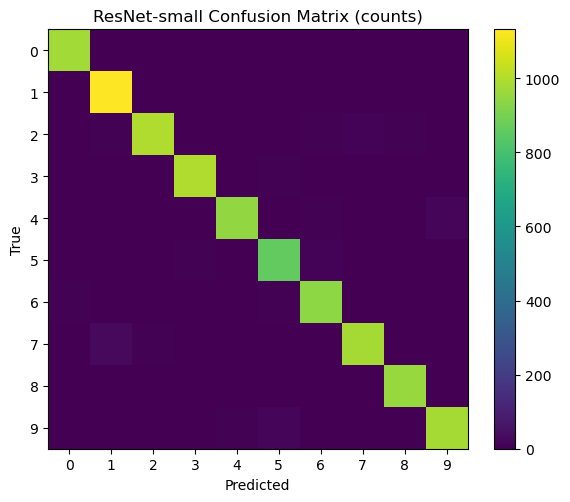

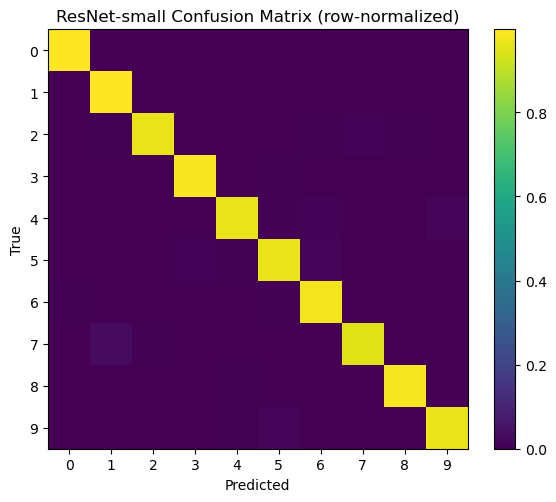

ResNet-small ROC AUC — macro: 0.9995, micro: 0.9995


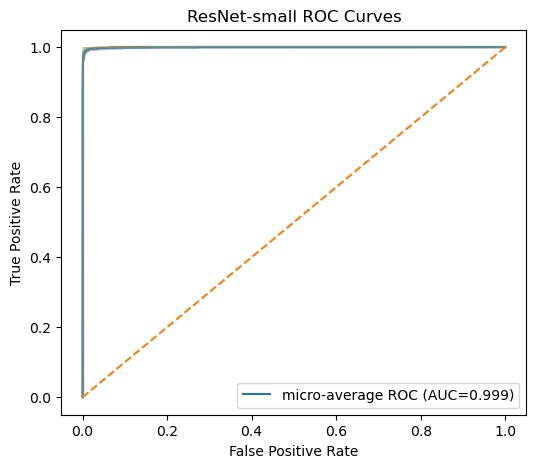

ResNet-small PRC AUC — avg per-class: 0.9968 ± 0.0019


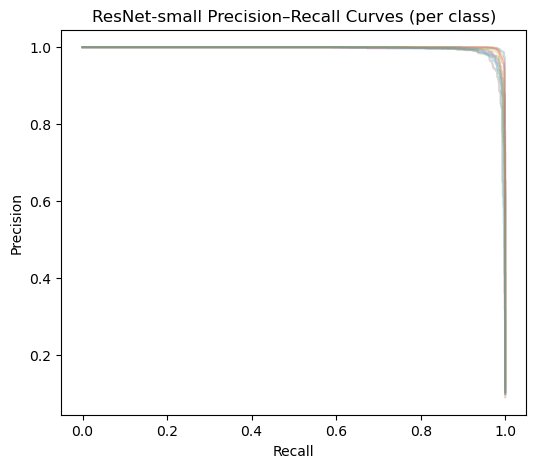

In [40]:
# 13) Small ResNet for grayscale 28x28
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match channels/stride for the shortcut if needed
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_small(input_shape=(28,28,1), num_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build model
resnet = build_resnet_small(X_train_cnn.shape[1:], num_classes)
resnet.summary()

print("Training small ResNet...")
# Important: use a fresh EarlyStopping (don't reuse from CNN!)
es_res = callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

hist_resnet = resnet.fit(
    X_train_cnn, y_train_full,
    validation_data=(X_val_cnn, y_val),
    epochs=40, batch_size=256,
    callbacks=[es_res],
    class_weight=class_weights,
    verbose=2
)

print("Evaluate ResNet on test set...")
test_loss_res, test_acc_res = resnet.evaluate(X_test_cnn, y_test_oh, verbose=0)
print(f"ResNet Test accuracy: {test_acc_res:.4f}")

# Optional: evaluate plots
evaluate_model(resnet, X_test_cnn, y_test_oh, y_test, model_name="ResNet-small")

**Training dynamics (40-epoch cap, batch size 256).**  
- **Warm-up effect:** Epoch 1 shows **val_acc ≈ 0.11** (near chance) while train accuracy is already 0.69. This transient is typical with **BatchNorm** + fresh moving statistics; it vanishes immediately.  
- **Rapid climb:** By **epoch 3**, validation accuracy jumps to **0.945**; from there it oscillates in the **0.95–0.97** range.  
- **Best epoch & early stopping:** The best validation accuracy occurs at **epoch 14 (0.9717)**. Training ran to epoch 20, then **EarlyStopping** restored weights from epoch 14.

**Test performance.**  
- **Test accuracy = 0.9763.**  
- **Classification report (per class):** precision/recall are **≥0.95** for all digits.  
  - Very strong: digits **0, 1, 3, 8, 9** (e.g., `0`: P=0.984, R=0.997; `3`: P=0.987, R=0.986).  
  - Slightly lower recall: **2 (R=0.964)** and **7 (R=0.954)**, consistent with occasional confusions of “2/7/1/9” in handwritten styles.  
- **Macro averages:** Precision **0.9763**, Recall **0.9760**, F1 **0.9761**, matching overall accuracy—performance is **uniform across classes**.

**Why this model works well (and efficiently).**  
- **Residual connections** ease optimization and preserve gradient flow, enabling deeper feature learning than the small CNN/MLP baselines.  
- **BatchNorm** stabilizes training and lets us use a larger learning rate.  
- **Global Average Pooling** drastically reduces parameters vs. fully connected heads and acts as regularization.  
- With only **~171k parameters** (≈ **64% fewer** than the plain CNN’s ~468k), it still **outperforms** it on test accuracy.

**Comparison to earlier models.**
- **MLP (flattened pixels):** 0.849 → **ResNet +12.7 points** absolute, eliminating most shape-based confusions.  
- **Plain CNN:** 0.971 → **ResNet +0.49 points** with **far fewer parameters**, showing the benefit of residual blocks + BN + GAP.


### Test-set diagnostics (confusion matrix, ROC, PR)

### A) Confusion matrices (counts and row-normalized)
**What they show.**  
- **Counts matrix:** raw number of test images per (true, predicted) pair.  
- **Row-normalized matrix:** each row sums to 1, so the diagonal entries are class-wise **recall**; off-diagonals are per-class error rates.

**How to read them.**  
- A perfect model has a bright diagonal and dark off-diagonals. Any bright off-diagonal cell pinpoints a **specific confusion** (e.g., true “4” predicted as “9”).

**ResNet-small observations (Acc = 0.9763).**  
- The diagonal is uniformly bright; off-diagonals are extremely faint ⇒ **very few confusions**.  
- From the row-normalized view (and the report): recalls are **≥ 0.95** for all digits, with the lowest around **7 (0.954)** and **2 (0.964)**; most others are ~0.97–0.99.  
- The remaining errors match known handwriting ambiguities (e.g., **2/7/1/9**, **4/9**).

---

### B) ROC curves (one-vs-rest; micro + per-class overlays)
**What they show.**  
For each digit vs the rest, the ROC plots **TPR vs FPR** as the decision threshold varies. The **AUC** summarizes separability across all thresholds (1.0 is perfect).

**How to use them.**  
- Curves hugging the **top-left** corner indicate excellent ranking quality regardless of operating threshold.

**ResNet-small results.**  
- **Micro AUC = 0.9995**, **Macro AUC = 0.9995** — essentially ceiling performance.  
- All per-class ROC curves are indistinguishable near the top-left, confirming **near-perfect separability**.

---

### C) Precision–Recall (PR) curves (per class)
**What they show.**  
PR curves plot **Precision vs Recall** as the threshold moves. They are especially informative when focusing on **high-precision** or **high-recall** regimes.

**ResNet-small results.**  
- Average per-class **PR-AUC = 0.9968 ± 0.0019**.  
- Curves stay pinned near the **top** until very high recall, meaning ResNet-small maintains **both** low false-positive and low false-negative rates across thresholds.

---

### D) Putting it together (and comparing to earlier models)
- **Overall accuracy:** **ResNet-small 97.63%** > **CNN 97.14%** > **MLP 84.91%**.  
- **Threshold-free quality:** ROC-AUC and PR-AUC are **near-perfect** for ResNet-small (≈0.9995 ROC, ≈0.997 PR), edging out the plain CNN (≈0.9993 ROC, ≈0.995 PR) and far surpassing the MLP (≈0.986 ROC, ≈0.914 PR).  
- **Error structure:** Confusion matrices show that ResNet-small **eliminates almost all systematic confusions** left by the MLP and reduces the already-small ones from the CNN.  
- **Efficiency note:** Despite its superior metrics, ResNet-small uses **~171k params** (vs **~468k** for the plain CNN), thanks to **residual blocks**, **BatchNorm**, and a **Global Average Pooling** head.

**Takeaway.**  
These diagnostics agree: ResNet-small delivers **uniformly strong per-class performance** with **near-ceiling ranking quality** and **minimal confusions**, providing a compact yet state-of-the-art baseline on MNIST.


## 14) Side-by-side summary and takeaways


In [41]:
# 15) Compare the different approaches we tried
# 15) Summary: test accuracies + CV (si dispo)

summary_rows = []

# Ajoute MLP v1 si entraîné
if "test_acc_mlp" in globals():
    summary_rows.append(("MLP (Dense v1, test)", test_acc_mlp))

# Ajoute CNN si entraîné
if "test_acc_cnn" in globals():
    summary_rows.append(("CNN (Conv2D, test)", test_acc_cnn))

# Ajoute ResNet si entraîné
if "test_acc_res" in globals():
    summary_rows.append(("ResNet-small (test)", test_acc_res))

print("\n=== Summary of accuracies ===")
for name, acc in summary_rows:
    print(f"{name:25s} : {acc:.4f}")

# Ajoute la CV si elle existe (métrique de validation, pas test)
if "fold_accuracies" in globals() and len(fold_accuracies) > 0:
    cv_mean_acc = float(np.mean(fold_accuracies))
    cv_std_acc  = float(np.std(fold_accuracies))
    print(f"{'MLP (5-fold CV, val)':25s} : {cv_mean_acc:.4f}")
    print(f"   (CV std: {cv_std_acc:.4f})")




=== Summary of accuracies ===
MLP (Dense v1, test)      : 0.8491
CNN (Conv2D, test)        : 0.9714
ResNet-small (test)       : 0.9763
MLP (5-fold CV, val)      : 0.8193
   (CV std: 0.0026)


**Test accuracy (higher is better).**
- **MLP (Dense):** **0.8491**
- **CNN (Conv2D):** **0.9714**  _( +0.1223 vs MLP )_
- **ResNet-small:** **0.9763**  _( +0.0049 vs CNN; +0.1272 vs MLP )_

**Validation CV for MLP (5-fold, stratified).**
- Mean **0.8193**, Std **0.0026** (tight spread).  
- Slightly below the single split’s test score because each fold trains on 80% of the data and no per-fold tuning is done.

**Error rates (1 − accuracy; lower is better).**
- MLP: **15.09%**
- CNN: **2.86%**  → **~81%** error reduction vs MLP (0.1509 → 0.0286).
- ResNet-small: **2.37%**  → **~17%** error reduction vs CNN (0.0286 → 0.0237), **~84%** vs MLP (0.1509 → 0.0237).

**Threshold-free metrics (test set).**
- **ROC-AUC (macro / micro):**  
  - MLP: **0.984 / 0.986**  
  - CNN: **0.9993 / 0.9993**  
  - ResNet-small: **0.9995 / 0.9995**
- **PR-AUC (avg per-class ± std):**  
  - MLP: **0.914 ± 0.043**  
  - CNN: **0.995 ± 0.002**  
  - ResNet-small: **0.997 ± 0.002**

**Confusion-matrix takeaways.**
- **MLP:** Clear off-diagonal mass for look-alike digits (**4↔9**, **5↔6**, some **2/7/1/9**).  
- **CNN:** Diagonal dominates; only faint residual confusions remain.  
- **ResNet-small:** Diagonal is near-perfect; per-class recall typically **≥0.96**, with the rarest slips around **2** and **7**.

**Model size (trainable parameters).**
- **MLP:** ~**235k**  
- **CNN:** ~**468k**  
- **ResNet-small:** ~**171k**  → ~**63.5% fewer** params than the CNN, ~**27% fewer** than the MLP, **yet the best accuracy**.

**Why performance differs.**
- **MLP** ignores spatial structure (flattened pixels), so it plateaus ≈**85%**.  
- **CNN** learns local edges/parts with shared kernels + pooling → big jump to **97%**.  
- **ResNet-small** adds **residual connections + BatchNorm + GAP**, enabling deeper, better-normalized features with **fewer parameters** → **97.6%**.

**What to report.**
- Use **ResNet-small** as the best compact model (**0.9763** test; near-ceiling ROC/PR; clean confusion matrix).  
- Keep **CNN** as a strong, simple baseline (**0.9714**).  
- Use **MLP** as the non-convolutional baseline (**0.8491**, CV ≈**0.819**), helpful for highlighting the benefit of spatial inductive bias.